## 1.1 Important info

# 1. Ideas

**Goals**: Predict likelyhood of accidents of different types of road \
**Evaluation**: Root Mean Squared Error


# 2. Data Processing

In [1]:
import pandas as pd

raw = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv", index_col = "id")
raw.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [2]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [3]:
print("Unique types of categorical columns: ")
for col in raw.select_dtypes(include = ["object"]):
    print("   ", col, ": ", list(raw[col].unique()))

Unique types of categorical columns: 
    road_type :  ['urban', 'rural', 'highway']
    lighting :  ['daylight', 'dim', 'night']
    weather :  ['rainy', 'clear', 'foggy']
    time_of_day :  ['afternoon', 'evening', 'morning']


In [4]:
print("Columns with Boolean value: ",)
print([col for col in raw.select_dtypes(include = ["bool"])])

Columns with Boolean value: 
['road_signs_present', 'public_road', 'holiday', 'school_season']


In [5]:
print("Column with numeric value: ")
print([col for col in raw.select_dtypes(include = ["number"])])

Column with numeric value: 
['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'accident_risk']


In [6]:
print("Number of Nan values in each columns")
print(raw.isna().sum())

Number of Nan values in each columns
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


## 2.1 Process categorical data

**Hypothesis**: 
- The darker, the risker to drive
- Rain and foggy has the same risk while clear sky poses no risk
- Highway poses less risk than urban and rural area

In [7]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cat_col = [col for col in raw.select_dtypes(include = ["object"])]

categorical = raw[cat_col +["accident_risk"]]
categorical

,road_type,lighting,weather,time_of_day,accident_risk
id,,,,,
0,urban,daylight,rainy,afternoon,0.13
1,urban,daylight,clear,evening,0.35
2,rural,dim,clear,morning,0.30
3,highway,dim,rainy,morning,0.21
4,rural,daylight,foggy,evening,0.56
...,...,...,...,...,...
517749,highway,daylight,foggy,afternoon,0.32
517750,rural,daylight,rainy,morning,0.26
517751,urban,daylight,foggy,afternoon,0.19


In [8]:
for col in cat_col:
    print(categorical[col].value_counts())

road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64
lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64
weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64
time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64


In [9]:
class RoadWeatherEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapping_road = {"urban": 1, "rural": 1, "highway": 0}
        self.mapping_weather = {"rainy": 1, "clear": 0, "foggy": 1}
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X["road_type_encoded"] = X["road_type"].map(self.mapping_road)
        X["weather_encoded"] = X["weather"].map(self.mapping_weather)
        X.drop(columns=["road_type", "weather"], inplace=True)
        return X

    def get_feature_names_out(self, input_features=None):
        return ["road_type_encoded", "weather_encoded"]


In [10]:
OHEncoder = OneHotEncoder()

cat_processor = ColumnTransformer(transformers = [
    ("OneHot Encode", OHEncoder, cat_col),
    ("Label Encode lightning", OrdinalEncoder(categories=[["daylight", "dim", "night"]], ), ["lighting"]),
    ("Label Encode time", OrdinalEncoder(categories=[["morning", "afternoon", "evening"]]), ["time_of_day"]),
    ("Road Weather Encoder", RoadWeatherEncoder(), ["road_type", "weather"]),
], remainder="passthrough")

In [11]:
cat_transformed = cat_processor.fit_transform(categorical)
cat_transformed, cat_transformed.shape

(array([[0.  , 0.  , 1.  , ..., 1.  , 1.  , 0.13],
        [0.  , 0.  , 1.  , ..., 1.  , 0.  , 0.35],
        [0.  , 1.  , 0.  , ..., 1.  , 0.  , 0.3 ],
        ...,
        [0.  , 0.  , 1.  , ..., 1.  , 1.  , 0.19],
        [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.51],
        [1.  , 0.  , 0.  , ..., 0.  , 1.  , 0.22]]),
 (517754, 17))

In [12]:
column_name = cat_processor.get_feature_names_out()
column_name

array(['OneHot Encode__road_type_highway',
       'OneHot Encode__road_type_rural', 'OneHot Encode__road_type_urban',
       'OneHot Encode__lighting_daylight', 'OneHot Encode__lighting_dim',
       'OneHot Encode__lighting_night', 'OneHot Encode__weather_clear',
       'OneHot Encode__weather_foggy', 'OneHot Encode__weather_rainy',
       'OneHot Encode__time_of_day_afternoon',
       'OneHot Encode__time_of_day_evening',
       'OneHot Encode__time_of_day_morning',
       'Label Encode lightning__lighting',
       'Label Encode time__time_of_day',
       'Road Weather Encoder__road_type_encoded',
       'Road Weather Encoder__weather_encoded',
       'remainder__accident_risk'], dtype=object)

In [13]:
transformed_cat_df = pd.DataFrame(cat_transformed, columns=column_name)
transformed_cat_df

,OneHot Encode__road_type_highway,OneHot Encode__road_type_rural,OneHot Encode__road_type_urban,OneHot Encode__lighting_daylight,OneHot Encode__lighting_dim,OneHot Encode__lighting_night,OneHot Encode__weather_clear,OneHot Encode__weather_foggy,OneHot Encode__weather_rainy,OneHot Encode__time_of_day_afternoon,OneHot Encode__time_of_day_evening,OneHot Encode__time_of_day_morning,Label Encode lightning__lighting,Label Encode time__time_of_day,Road Weather Encoder__road_type_encoded,Road Weather Encoder__weather_encoded,remainder__accident_risk
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.13
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.35
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.30
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.21
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.32
517750,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.26
517751,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.19
517752,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.51


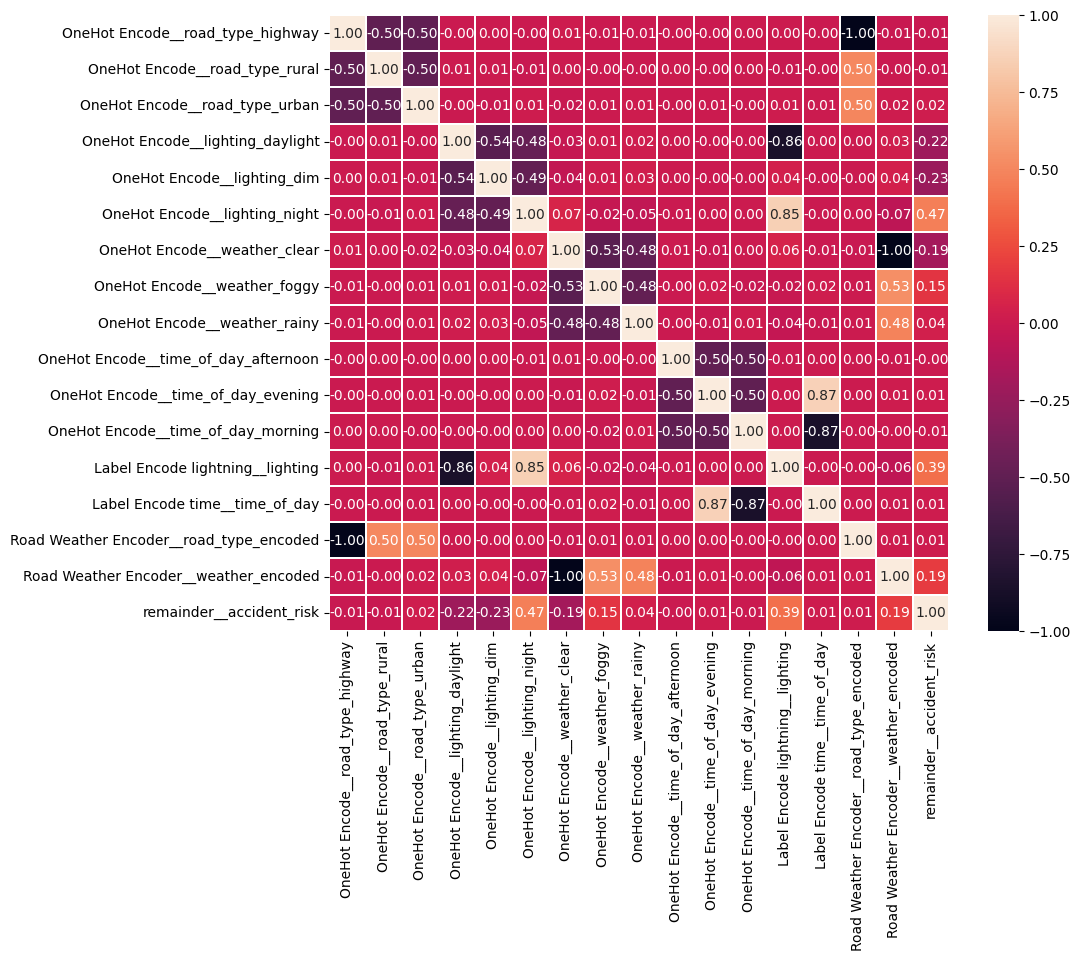

In [14]:
correlation = transformed_cat_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, linewidths=.3, annot=True, fmt=".2f")

plt.show()

**Useful Feature to keep**
- One-hot encode of day lighting (all features)
- One-hot encode of weather foggy/clear
- label encode of lighting
- label encode of weather

In [15]:
# keep_cat_col = ['OneHot Encode__lighting_daylight', 
#                 'OneHot Encode__lighting_dim',
#                 'OneHot Encode__lighting_night', 
#                 'OneHot Encode__weather_clear',
#                 'OneHot Encode__weather_foggy', 
#                 'Label Encode lightning__lighting',
#                 'Road Weather Encoder__weather_encoded',
#                ]


original_features = column_name[:-1]
keep_cat_col = original_features

keep_cat_id = [i for i in range(len(original_features)) if original_features[i] in keep_cat_col]
keep_cat_id

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [16]:
class ColumnFilter(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:, self.columns]

In [17]:
cat_pipeline = Pipeline(steps=[
    ("Data processing", cat_processor),
    ("Data cleaning", ColumnFilter(keep_cat_id))
])

final_cat_transformed = cat_pipeline.fit_transform(categorical)
final_cat_transformed, final_cat_transformed.shape

(array([[0., 0., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 2., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 1., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 1., 0., 1.]]),
 (517754, 16))

## 2.2 Process numeric data

In [18]:
num_col = [col for col in raw.select_dtypes(include = ["number"])]
num_col.remove("accident_risk")

numerical = raw[num_col +["accident_risk"]]
numerical

,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
id,,,,,
0,2,0.06,35,1,0.13
1,4,0.99,35,0,0.35
2,4,0.63,70,2,0.30
3,4,0.07,35,1,0.21
4,1,0.58,60,1,0.56
...,...,...,...,...,...
517749,4,0.10,70,2,0.32
517750,4,0.47,35,1,0.26
517751,4,0.62,25,0,0.19


In [19]:
num_col

['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

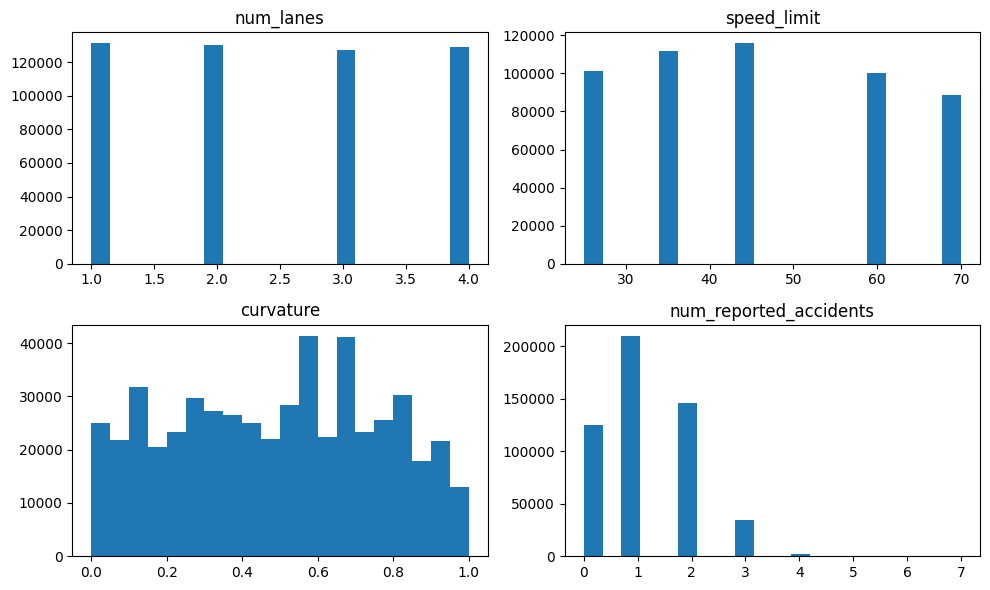

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for count, col in enumerate(num_col):
    axes[count%2, count//2].hist(numerical[col], bins=20)
    axes[count%2, count//2].set_title(col)

plt.tight_layout()  
plt.show()

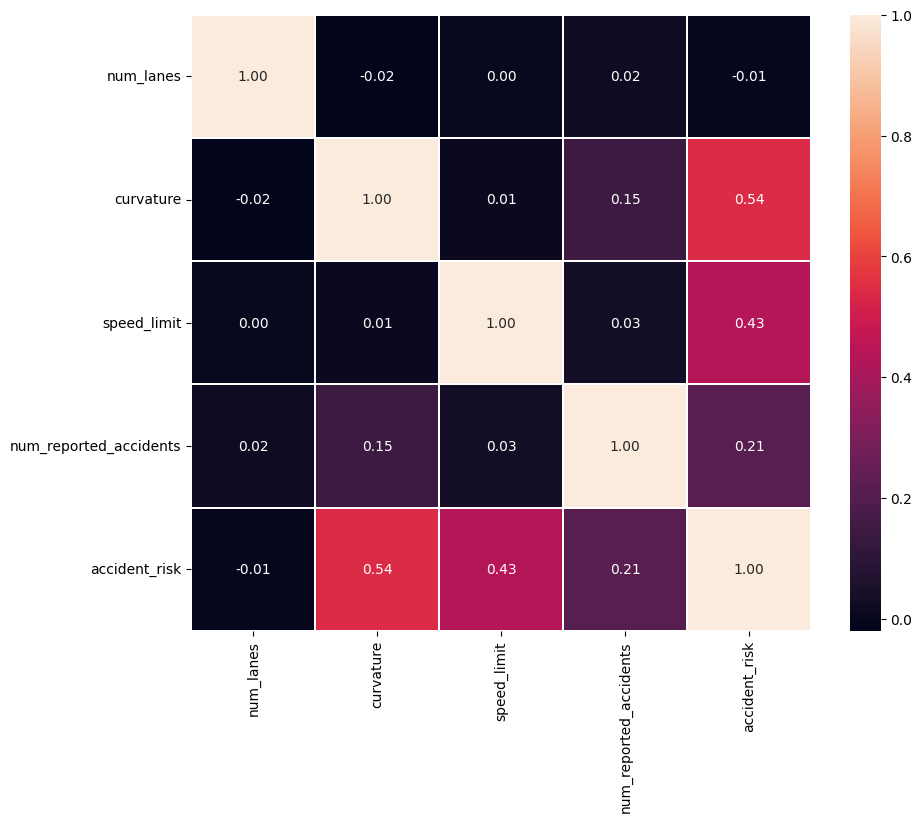

In [21]:
correlation = numerical.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, linewidths=.3, annot=True, fmt=".2f")

plt.show()

In [22]:
numerical.num_reported_accidents.value_counts()

num_reported_accidents
1    209674
2    145965
0    125269
3     34197
4      2392
5       231
6        24
7         2
Name: count, dtype: int64

In [23]:
class ReportedAccidentsBin(BaseEstimator, TransformerMixin):
    def __init__(self, column=["num_reported_accidents"]):
        self.column=column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[">=4 accidents"] = (X[self.column] >= 4).astype(int)
        return X

    def get_feature_names_out(self, input_features=None):
        return [">= 4 reported accidents"]

In [24]:
num_processor = ColumnTransformer([
    ("Encode many reported accident", ReportedAccidentsBin(), ["num_reported_accidents"])
], remainder="passthrough")

transformed_num = num_processor.fit_transform(numerical)
transformed_num, transformed_num.shape

(array([[1.0e+00, 0.0e+00, 2.0e+00, 6.0e-02, 3.5e+01, 1.3e-01],
        [0.0e+00, 0.0e+00, 4.0e+00, 9.9e-01, 3.5e+01, 3.5e-01],
        [2.0e+00, 0.0e+00, 4.0e+00, 6.3e-01, 7.0e+01, 3.0e-01],
        ...,
        [0.0e+00, 0.0e+00, 4.0e+00, 6.2e-01, 2.5e+01, 1.9e-01],
        [3.0e+00, 0.0e+00, 3.0e+00, 6.3e-01, 2.5e+01, 5.1e-01],
        [2.0e+00, 0.0e+00, 2.0e+00, 3.1e-01, 4.5e+01, 2.2e-01]]),
 (517754, 6))

In [25]:
num_processed_col = num_processor.get_feature_names_out()
num_processed_col = np.insert(num_processed_col, 0, "num_reported_accidents")
num_processed_col

array(['num_reported_accidents',
       'Encode many reported accident__>= 4 reported accidents',
       'remainder__num_lanes', 'remainder__curvature',
       'remainder__speed_limit', 'remainder__accident_risk'], dtype=object)

In [26]:
processed_num_df = pd.DataFrame(transformed_num, columns=num_processed_col)
processed_num_df

,num_reported_accidents,Encode many reported accident__>= 4 reported accidents,remainder__num_lanes,remainder__curvature,remainder__speed_limit,remainder__accident_risk
0,1.0,0.0,2.0,0.06,35.0,0.13
1,0.0,0.0,4.0,0.99,35.0,0.35
2,2.0,0.0,4.0,0.63,70.0,0.30
3,1.0,0.0,4.0,0.07,35.0,0.21
4,1.0,0.0,1.0,0.58,60.0,0.56
...,...,...,...,...,...,...
517749,2.0,0.0,4.0,0.10,70.0,0.32
517750,1.0,0.0,4.0,0.47,35.0,0.26
517751,0.0,0.0,4.0,0.62,25.0,0.19
517752,3.0,0.0,3.0,0.63,25.0,0.51


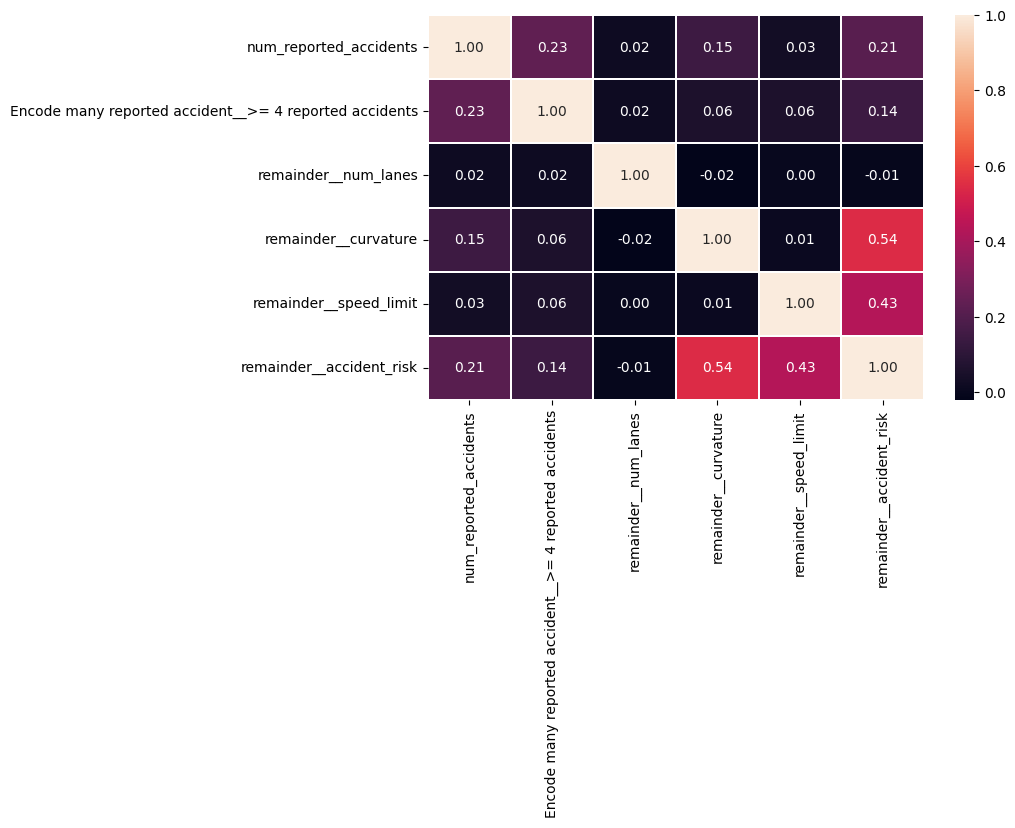

In [27]:
correlation = processed_num_df.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(correlation, linewidths=.3, annot=True, fmt=".2f")

plt.show()

## 2.3 Process Boolean data

In [28]:
num_pipeline = Pipeline([
    ("process numerical data", num_processor)
])

final_num_transformed = num_pipeline.fit_transform(numerical)
final_num_transformed, final_num_transformed.shape

(array([[1.0e+00, 0.0e+00, 2.0e+00, 6.0e-02, 3.5e+01, 1.3e-01],
        [0.0e+00, 0.0e+00, 4.0e+00, 9.9e-01, 3.5e+01, 3.5e-01],
        [2.0e+00, 0.0e+00, 4.0e+00, 6.3e-01, 7.0e+01, 3.0e-01],
        ...,
        [0.0e+00, 0.0e+00, 4.0e+00, 6.2e-01, 2.5e+01, 1.9e-01],
        [3.0e+00, 0.0e+00, 3.0e+00, 6.3e-01, 2.5e+01, 5.1e-01],
        [2.0e+00, 0.0e+00, 2.0e+00, 3.1e-01, 4.5e+01, 2.2e-01]]),
 (517754, 6))

In [29]:
boo_col = [col for col in raw.select_dtypes(include = ["boolean"])]

boolean = raw[boo_col +["accident_risk"]]
boolean = boolean.astype(int)
boolean

,road_signs_present,public_road,holiday,school_season,accident_risk
id,,,,,
0,0,1,0,1,0
1,1,0,1,1,0
2,0,1,1,0,0
3,1,1,0,0,0
4,0,0,1,0,0
...,...,...,...,...,...
517749,1,1,0,0,0
517750,1,1,0,0,0
517751,0,0,0,1,0


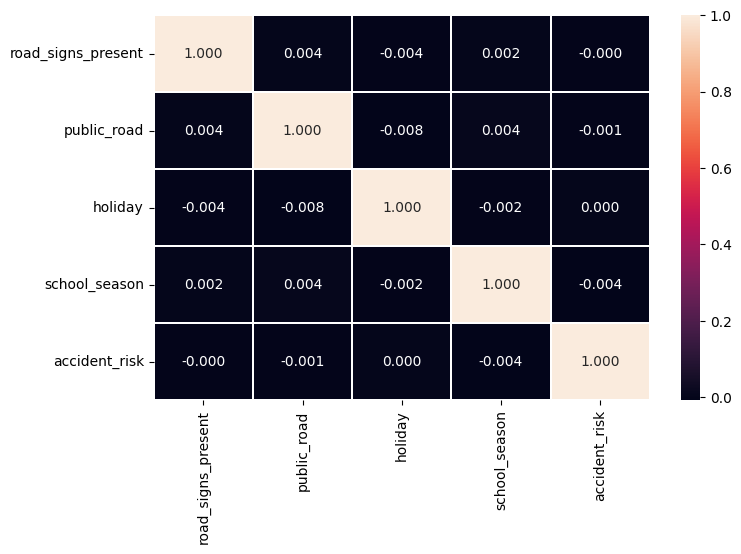

In [30]:
correlation = boolean.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(correlation, linewidths=.3, annot=True, fmt=".3f")

plt.show()

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.pipeline import Pipeline

class BooleanToInt(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns 
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].astype(int)
        return X[self.columns]
    


boo_pipeline = Pipeline([
    ("bool_to_int", BooleanToInt(columns=boo_col))
])

final_transformed_boo = boo_pipeline.fit_transform(boolean)
final_transformed_boo

,road_signs_present,public_road,holiday,school_season
id,,,,
0,0,1,0,1
1,1,0,1,1
2,0,1,1,0
3,1,1,0,0
4,0,0,1,0
...,...,...,...,...
517749,1,1,0,0
517750,1,1,0,0
517751,0,0,0,1


### 2.4 Process all data

In [32]:
from sklearn.preprocessing import StandardScaler

data, target = raw.drop(columns=["accident_risk"]), raw["accident_risk"]
print(data.shape, target.shape)

transformer = ColumnTransformer([
    ("Categorical", cat_pipeline, cat_col),
    ("Numerical", num_pipeline, num_col),
    ("Boolean", boo_pipeline, boo_col)
    
])

pipeline = Pipeline([
    ("Transformer", transformer),
    ("Scaling", StandardScaler())
])

processed_data = pipeline.fit_transform(data)
processed_data, processed_data.shape

(517754, 12) (517754,)


(array([[-0.71045067, -0.70751961,  1.42175502, ...,  0.99549834,
         -1.00702024,  1.00498389],
        [-0.71045067, -0.70751961,  1.42175502, ..., -1.00452202,
          0.9930287 ,  1.00498389],
        [-0.71045067,  1.41338839, -0.70335605, ...,  0.99549834,
          0.9930287 , -0.99504082],
        ...,
        [-0.71045067, -0.70751961,  1.42175502, ..., -1.00452202,
         -1.00702024,  1.00498389],
        [ 1.40755727, -0.70751961, -0.70335605, ..., -1.00452202,
          0.9930287 ,  1.00498389],
        [ 1.40755727, -0.70751961, -0.70335605, ...,  0.99549834,
          0.9930287 ,  1.00498389]]),
 (517754, 25))

# 3. Model

In [33]:
X, y = processed_data, target
X.shape, y.shape

((517754, 25), (517754,))

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((465978, 25), (465978,), (51776, 25), (51776,))

In [35]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [36]:
model = lgb.LGBMRegressor(n_estimators=50)

In [37]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
baseline_score = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer, n_jobs=-1)

In [38]:
print("Baseline RMSE (5-fold):", -baseline_score.mean(), "±", baseline_score.std())

Baseline RMSE (5-fold): 0.05638863317638837 ± 0.00010098729023572361


In [39]:
param_dist = {
    "n_estimators": [100, 300, 500],        # fewer boosting rounds, avoid 1000 unless CV says so
    "num_leaves": [7, 15, 31],              # smaller trees, prevents overfitting
    "learning_rate": [0.01, 0.05, 0.1],     # keep range
    "max_depth": [-1, 3, 6],                # shallow depth (-1 means no limit, but with small data, 3-6 is good)
    "subsample": [0.8, 1.0],                # row sampling, reduces variance
    "colsample_bytree": [0.8, 1.0],         # feature sampling
    "min_child_samples": [5, 10, 20],       # VERY important for small data, allow small leaves
    "reg_alpha": [0.0, 0.1, 1.0],           # L1 regularization
    "reg_lambda": [0.0, 0.1, 1.0]           # L2 regularization
}

randomSearch = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=4,
    scoring=rmse_scorer,
    cv=cv,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

In [40]:
randomSearch.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 25
[LightGBM] [Info] Start training from score 0.352605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 414204, number of used features: 25
[LightGBM] [Info] Start training from score 0.352433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067978 seconds.
You can set `force_row_w

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMRegressor(n_estimators=50), n_iter=4,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 3, 6],
                                        'min_child_samples': [5, 10, 20],
                                        'n_estimators': [100, 300, 500],
                                        'num_leaves': [7, 15, 31],
                                        'reg_alpha': [0.0, 0.1, 1.0],
                                        'reg_lambda': [0.0, 0.1, 1.0],
                                        'subsample': [0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=1)

In [41]:
print("Best RMSE:", -randomSearch.best_score_)
print("Best params:", randomSearch.best_params_)
final_model = randomSearch.best_estimator_

Best RMSE: 0.05629182555298294
Best params: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 15, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [42]:
final_model.fit(X_train, y_train)
pred = final_model.predict(X_val)

rmse(final_model.predict(X_train), y_train), rmse(pred, y_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 465978, number of used features: 25
[LightGBM] [Info] Start training from score 0.352476


(0.05616919410448876, 0.05622385037985435)

# 4. Submit

In [43]:
sample = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")
sample.head()

,id,accident_risk
0,517754,0.352
1,517755,0.352
2,517756,0.352
3,517757,0.352
4,517758,0.352


In [44]:
test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv", index_col = "id")
test.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
id,,,,,,,,,,,,
517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [45]:
transformed_test = pipeline.fit_transform(test)
transformed_test.shape

(172585, 25)

In [46]:
pred = final_model.predict(transformed_test)
pred

array([0.29242403, 0.12522942, 0.18420794, ..., 0.24926051, 0.12781006,
       0.491537  ])

In [47]:
id_col = test.index
id_col

Index([517754, 517755, 517756, 517757, 517758, 517759, 517760, 517761, 517762,
       517763,
       ...
       690329, 690330, 690331, 690332, 690333, 690334, 690335, 690336, 690337,
       690338],
      dtype='int64', name='id', length=172585)

In [48]:
submission = pd.DataFrame(
    {"id": id_col, 
     "accident_risk" : pred
    }
)

submission.to_csv("submission.csv", index=False)
submission

,id,accident_risk
0,517754,0.292424
1,517755,0.125229
2,517756,0.184208
3,517757,0.323909
4,517758,0.419170
...,...,...
172580,690334,0.110879
172581,690335,0.515903
172582,690336,0.249261
172583,690337,0.127810
